In [95]:
import os

import numpy as np
import qiskit.ignis.mitigation.measurement as mc
from dotenv import load_dotenv
from numpy import pi
from qiskit import (IBMQ, ClassicalRegister, QuantumCircuit, QuantumRegister,
                    transpile)
from qiskit.ignis.verification.tomography import (StateTomographyFitter,
                                                  state_tomography_circuits)
from qiskit.providers.aer import AerSimulator, noise
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.quantum_info import partial_trace
from qutip import Bloch, Bloch3d, Qobj

from sync_calcs import dm2bloch
from sync_gates import add_tomography

load_dotenv()

# IBMQ.ibmq.save_account(os.environ['TOKEN'], overwrite=True)


True

In [96]:
# IBMQ.load_account()
# provider = IBMQ.get_provider(group='open', project='main')
# job_manager = IBMQJobManager()

In [110]:
# backend = provider.get_backend('ibmq_quito') # Real
backend = provider.get_backend('ibmq_athens') # Real
# backend = provider.get_backend('ibmq_santiago') # Real - ibmq_santiago seems to have the lowest CNOT noise
# backend = AerSimulator.from_backend(backend) # Noisy Sim
# backend = AerSimulator() # Ideal Sim

# noise_model = noise.NoiseModel().from_backend(backend)

is_real_device = not backend.name().startswith('aer_simulator')

max_shots = backend.configuration().to_dict()["max_shots"]
max_shots

8192

# Parameters

In [98]:
# Simulation Steps
SIM_STEPS = 7
SHOTS = 8192

# Qubits of physical device to use
# Ordered from zero
main = 1
ancilla = 0

gain_amp = 0.1
loss_amp = 1
m = min(loss_amp, gain_amp)

detuning = 8 * 3 * m
signal_strength = 8 * 2 * m
# dt = 0.1
dt = (np.logspace(0.4, 0.8, SIM_STEPS, endpoint=True)) / 10
dt

array([0.25118864, 0.29286446, 0.34145489, 0.39810717, 0.46415888,
       0.54116953, 0.63095734])

# Circuit

In [99]:
def generate_circuit(time_steps, detuning, signal_strength, steps, main, ancilla):
    qreg_q = QuantumRegister(max(main, ancilla) + 1, "q")
    creg_c = ClassicalRegister(2, "c")

    qc = QuantumCircuit(qreg_q, creg_c)

    for i in range(steps):
        if hasattr(time_steps, "__iter__"):
            dt = time_steps[i]
        else:
            dt = time_steps
        theta_d = 2 * np.arcsin(np.sqrt(loss_amp * dt))
        theta_g = 2 * np.arcsin(np.sqrt(gain_amp * dt))

        theta = signal_strength * dt
        phi = pi - detuning * dt / 2
        lam = pi - detuning * dt / 2

        qc.u(theta, phi, lam, qreg_q[main])

        # Loss CU
        # qc.cu(theta_d, 0, 0, 0, qreg_q[main], qreg_q[ancilla])
        # qc.cx(qreg_q[ancilla], qreg_q[main])
        # qc.measure(qreg_q[ancilla], creg_c[0])
        # qc.reset(qreg_q[ancilla])

        # Loss 2xCX
        qc.u(pi / 2, -pi, 0, qreg_q[main])
        qc.u(-theta_d / 2, -pi / 2, pi, qreg_q[ancilla])
        qc.cx(qreg_q[ancilla], qreg_q[main])
        qc.u(pi / 2, -pi / 2, 0, qreg_q[main])
        qc.u(-theta_d / 2, pi, pi / 2, qreg_q[ancilla])
        qc.cx(qreg_q[ancilla], qreg_q[main])
        qc.u(0, 0, -pi / 2, qreg_q[main])
        qc.u(0, 0, -pi / 2, qreg_q[ancilla])
        qc.measure(qreg_q[ancilla], creg_c[0])
        qc.reset(qreg_q[ancilla])

        # # Gain
        qc.u(-pi, 0, 0, qreg_q[main])
        qc.cx(qreg_q[main], qreg_q[ancilla])
        qc.cu(theta_g, 0, 0, 0, qreg_q[main], qreg_q[ancilla])
        qc.cx(qreg_q[main], qreg_q[ancilla])
        qc.u(pi, 0, 0, qreg_q[main])
        qc.measure(qreg_q[ancilla], creg_c[0])
        qc.reset(qreg_q[ancilla])

    # qc.measure(qreg_q[0], creg_c[1])

    return qc


# Tomography

In [100]:
circuits = [generate_circuit(dt, detuning, signal_strength, i, main, ancilla) for i in range(0, SIM_STEPS + 1)]

circuits_with_tomo = [list(add_tomography(circuit, 2, main, ancilla)) for circuit in circuits]

compiled_circuits_with_tomo = [transpile(circuit, backend) for circuit in circuits_with_tomo]

# Calibration

In [119]:
measurement_calibration_circuit, state_labels = mc.complete_meas_cal(qubit_list=[main, ancilla])

if is_real_device:
    calibration_job = job_manager.run(measurement_calibration_circuit, backend=backend, name="QSync_calibration")
    result = calibration_job.results().combine_results()
else:
    calibration_job = backend.run(measurement_calibration_circuit, shots=SHOTS)
    result = calibration_job.result()

measurement_calibration_fitter = mc.CompleteMeasFitter(result, state_labels)
measurement_calibration_fitter.cal_matrix

array([[9.93164062e-01, 1.85546875e-02, 2.24609375e-02, 0.00000000e+00],
       [3.90625000e-03, 9.80468750e-01, 0.00000000e+00, 1.85546875e-02],
       [2.92968750e-03, 0.00000000e+00, 9.72656250e-01, 1.75781250e-02],
       [0.00000000e+00, 9.76562500e-04, 4.88281250e-03, 9.63867188e-01]])

# Simulation

In [134]:
jobs = []
if not is_real_device:
    for i, circuit in enumerate(compiled_circuits_with_tomo):
        print(f"Job Submission {i} of {len(compiled_circuits_with_tomo)}")
        job = backend.run(circuit, name=f"QSync_{i}", shots=SHOTS)
        jobs.append(job)
else:
    for i, circuit in enumerate(compiled_circuits_with_tomo):
        print(f"Job Submission {i} of {len(compiled_circuits_with_tomo)}")
        job = job_manager.run(circuit, backend=backend, name=f"QSync_{i}", shots=SHOTS)
        jobs.append(job)

Job Submission 0 of 8
Job Submission 1 of 8
Job Submission 2 of 8
Job Submission 3 of 8
Job Submission 4 of 8
Job Submission 5 of 8
Job Submission 6 of 8
Job Submission 7 of 8


managedjob._async_submit:WARNING:2021-05-18 15:30:52,329: Job limit reached, waiting for job 60a3cf9c48612b65bb2914fc to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-18 15:30:52,419: Job limit reached, waiting for job 60a3cf9c48612b65bb2914fc to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-18 15:30:52,436: Job limit reached, waiting for job 60a3cf9c48612b65bb2914fc to finish before submitting the next one.


In [135]:
uncorrected_states = []

for i, (job, circuit) in enumerate(zip(jobs, compiled_circuits_with_tomo)):
    if not is_real_device:
        result = job.result()
    else:
        result = job.results().combine_results()

    tomo_state = StateTomographyFitter(result, circuit)
    state = tomo_state.fit(method="lstsq")

    uncorrected_states.append(state)


managedjob._async_submit:WARNING:2021-05-18 15:35:53,614: Job limit reached, waiting for job 60a3cf9c48612b65bb2914fc to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-18 15:35:54,242: Job limit reached, waiting for job 60a3cf9c48612b65bb2914fc to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-18 15:35:54,338: Job limit reached, waiting for job 60a3cf9c48612b65bb2914fc to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-18 15:40:55,306: Job limit reached, waiting for job 60a3cf9c48612b65bb2914fc to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-18 15:40:56,035: Job limit reached, waiting for job 60a3cf9c48612b65bb2914fc to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-18 15:40:56,049: Job limit reached, waiting for job 60a3cf9c48612b65bb2914fc to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05

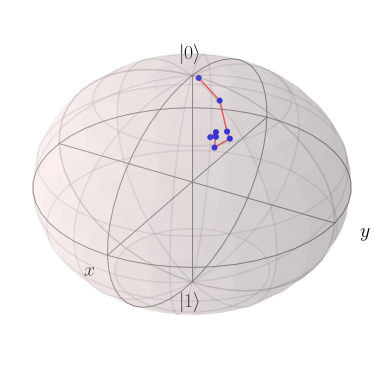

In [136]:
b = Bloch()
states = [partial_trace(s, [1]).data for s in uncorrected_states]
points = dm2bloch(states)
b.add_points(points, meth="s")
b.add_points(points, meth="l")

# b.view = [0, 90]
b.show()

In [137]:
if is_real_device:
    # Save job ids for later retrieval
    name = input("Jobs File Name: ")

    with open(f"{name}.txt", "w") as f:
        f.write("Calibration:\n")
        f.write(f"{calibration_job.job_set_id()}\n")
        f.write("\n")
        f.write("Simulation:\n")
        for job in jobs:
            id_ = job.job_set_id()
            f.write(f"{id_}\n")

In [138]:
corrected_states = []

for job, circuit in zip(jobs, compiled_circuits_with_tomo):
    if not is_real_device:
        result = job.result()
    else:
        result = job.results().combine_results()

    corrected_result = measurement_calibration_fitter.filter.apply(result, method="least_squares")
    mitigated_tomo_state = StateTomographyFitter(corrected_result, circuit)
    state = mitigated_tomo_state.fit(method="lstsq")

    corrected_states.append(state)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.9607803 +0.j         -0.01770361+0.01203497j]
 [-0.01770361-0.01203497j  0.0392197 +0.j        ]]

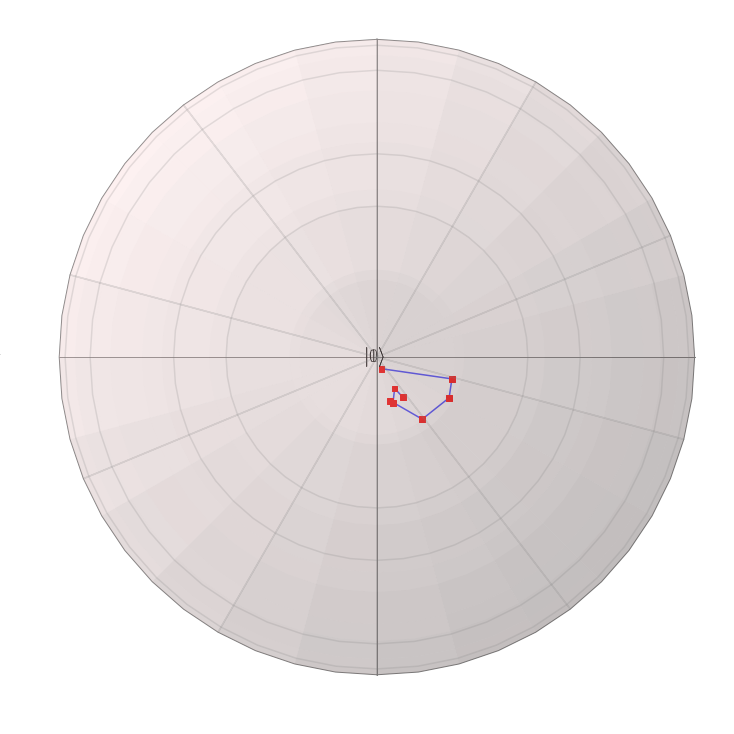

In [139]:
b = Bloch(figsize=[10, 10])
# b = Bloch3d()
states = [partial_trace(s, [1]).data for s in corrected_states][:13]
points = dm2bloch(states)
b.add_points(points, meth="l")
b.add_points(points, meth="s")
# b.add_points(points, meth="s")
b.view = [0, 90]
b.show()
Qobj(corrected_states[-1], dims=[[2, 2], [2, 2]]).ptrace(0)

(<Figure size 963.78x297.824 with 3 Axes>,
 (<AxesSubplot:xlabel='$\\varphi$', ylabel='$\\theta$'>,
  <AxesSubplot:xlabel='$\\varphi$', ylabel='$S(\\varphi\\,|\\,\\hat\\rho)$'>))

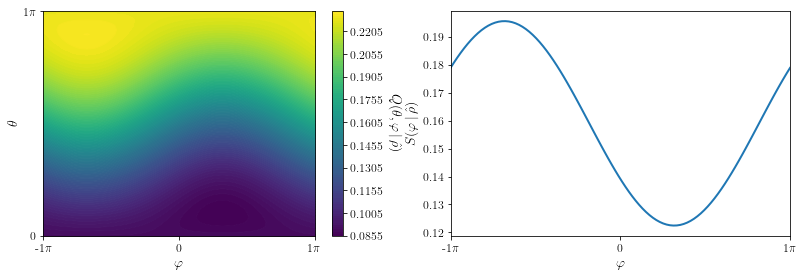

In [141]:
from sync_plots import calc_and_plot_Q_and_S
ss = partial_trace(corrected_states[-1], [1]).data
calc_and_plot_Q_and_S(Qobj(ss), method="qutip")

In [140]:
if is_real_device:
    # Save job ids for later retrieval
    name = input("Data File Name: ")
    np.save(f'{name}.npy', [partial_trace(s, [1]).data for s in corrected_states])